# Human Action Recognition

Base Models used iin this notebook:
- VGG19
- Inception
- Exception

In [1]:
import numpy as np
import pandas as pd

In [2]:
TRAINING_EPOCHS = 10
BATCH_SIZE = 32

image_height = 180 
image_width = 300

#### Loading data

In [3]:
# path to the data files
main_path = "/kaggle/input/human-action-dataset/Dataset/Data"

# Load data
train_df     = pd.read_csv("/kaggle/input/human-action-dataset/Dataset/Training_set.csv")
test_df = pd.read_csv("/kaggle/input/human-action-dataset/Dataset/Testing_set.csv")

In [4]:
# validation set
valid_df = train_df.groupby('label').apply(lambda x: x.sample(frac=0.10))
valid_df = valid_df.droplevel(0)
train_df = train_df.drop(valid_df.index)

In [5]:
train_df.head()

filename         label
0  Image_1.jpg       sitting
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop
5  Image_6.jpg      sleeping

In [6]:
freq = train_df['label'].value_counts()
train_freq = train_df['label'].value_counts()
valid_freq = valid_df['label'].value_counts()

print(freq,"\n\n", train_freq,"\n\n",valid_freq)
print()

sitting               756
hugging               756
sleeping              756
using_laptop          756
drinking              756
clapping              756
dancing               756
cycling               756
calling               756
eating                756
fighting              756
listening_to_music    756
laughing              756
running               756
texting               756
Name: label, dtype: int64 

 sitting               756
hugging               756
sleeping              756
using_laptop          756
drinking              756
clapping              756
dancing               756
cycling               756
calling               756
eating                756
fighting              756
listening_to_music    756
laughing              756
running               756
texting               756
Name: label, dtype: int64 

 calling               84
clapping              84
cycling               84
dancing               84
drinking              84
eating                84
fighting    

In [7]:
test_df.head()

filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg

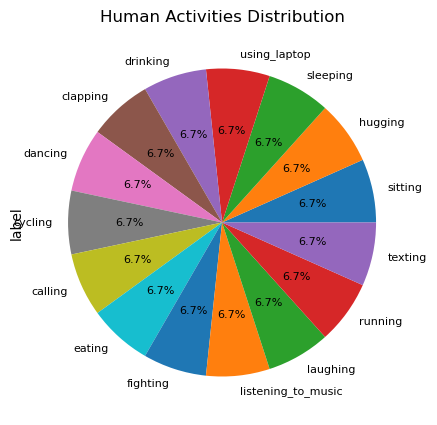

In [8]:
freq.plot(kind='pie',figsize=(5,5),title='Human Activities Distribution',autopct='%1.1f%%',shadow = False,  fontsize=8);

#### Data Generators

In [9]:
# Imports
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [10]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(rescale         = 1./255.,
                         horizontal_flip = True,
                         vertical_flip   = False,
                         zoom_range      = 0.05,
                         rotation_range  = 25)
 
train_generator = gen.flow_from_dataframe(
    train_df, # dataframe
    directory = main_path + "/train", # images data path / folder in which images are there
    x_col = 'filename',
    y_col = 'label',
    color_mode = "rgb",
    target_size = (180, 300), # image height , image width
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 42)

Found 11340 validated image filenames belonging to 15 classes.


In [11]:
# Data agumentation and pre-processing using tensorflow
test_gen = ImageDataGenerator(rescale = 1./255.)

test_generator = test_gen.flow_from_dataframe(
    test_df, # dataframe
    directory   = main_path + "/test", # images data path / folder in which images are there
    x_col       = 'filename',
    #y_col       = 'labels',
    color_mode  = "rgb",
    target_size = (180, 300), # image height , image width
    class_mode = None,
    batch_size  = 32,
    shuffle  = False)

Found 5400 validated image filenames.


In [12]:
validation_generator = test_gen.flow_from_dataframe(
    valid_df, # dataframe
    directory   = main_path + "/train", # images data path / folder in which images are there
    x_col       = 'filename',
    y_col       = 'label',
    color_mode  ="rgb",
    target_size = (180, 300), # image height , image width
    class_mode  = "categorical",
    batch_size  = 32,
    shuffle     = False,
    seed        = 42)

Found 1260 validated image filenames belonging to 15 classes.


In [13]:
# Get labels in dataset
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list

In [14]:
class_names

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'listening_to_music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

In [15]:
# Define function to plot some images
import matplotlib.pyplot as plt

def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[12, 18])
    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            if true_labels is not None:
                plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
            else:
                plt.title("{} {:.1f}%".format(class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i]))) 
        else:
            if true_labels is not None:
                plt.title(class_names[np.argmax(true_labels[i])])    

In [16]:
!pip3 install seaborn

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)
    ax.set_title(title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)
    ax.set_xlabel('Predicted Label', fontsize = 10)

In [18]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

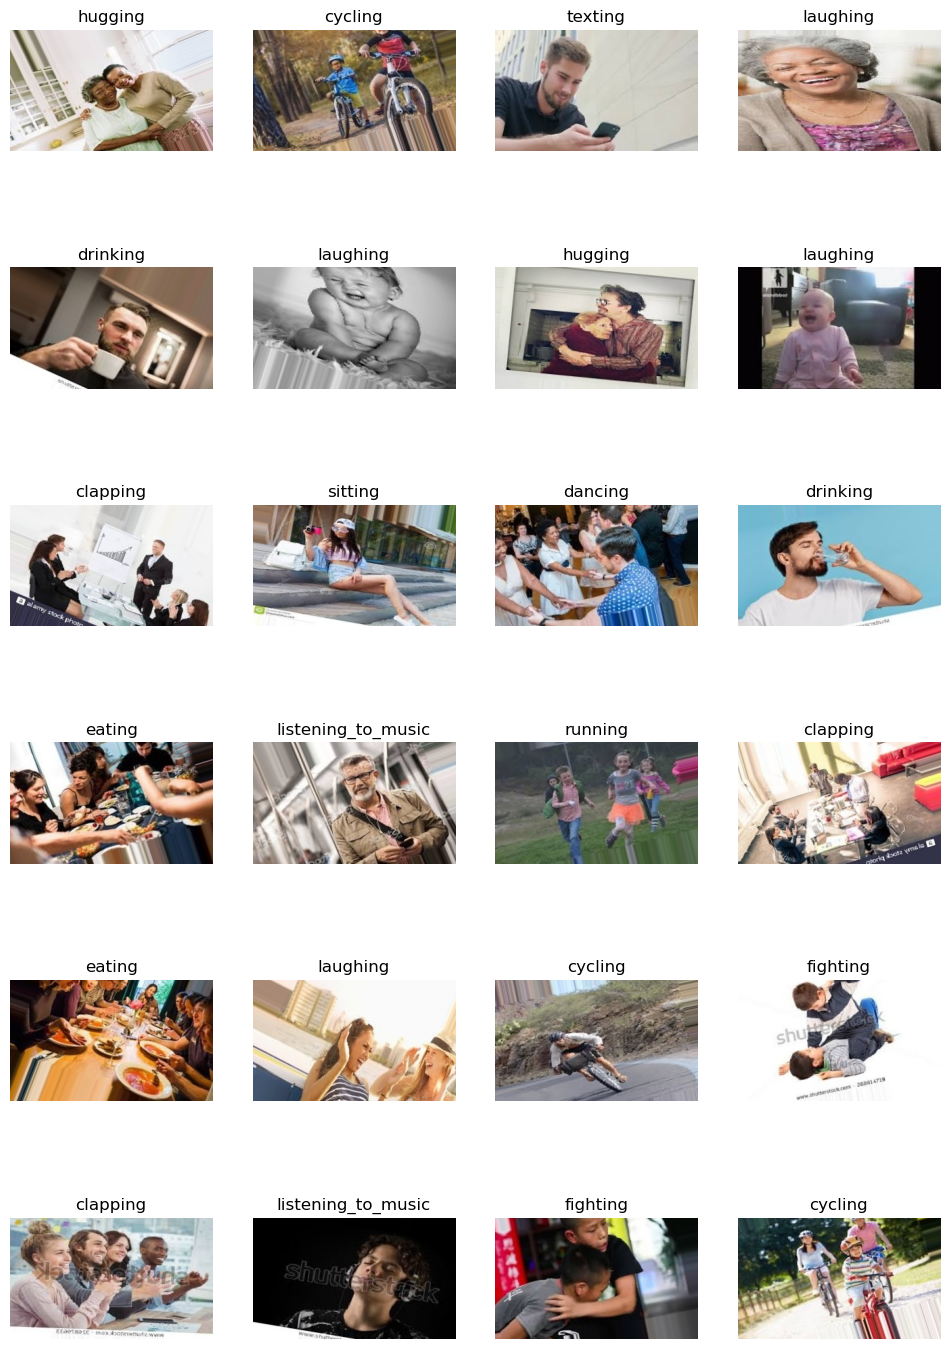

In [19]:
x,y = next(train_generator)
plot_images(x,y)

#### Model Initialisation

In [20]:
from keras.models import Model

def create_model(base_model):
    
    x = base_model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(base_model.inputs, outputs)
    
    return model  

In [21]:
def fit_model(model, base_model, epochs, fine_tune = 0):
    
    early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                              min_delta = 0.001,
                                              restore_best_weights = True)
    
    print("Unfreezing number of layers in base model = ", fine_tune)
    
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False       
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs = epochs,
                        callbacks = [early])
    
    return history

#### Approach 1: Using VGG19 as base model

In [22]:
# load the VGG19 architecture with imagenet weights as base
vgg19_base_model = tf.keras.applications.vgg19.VGG19(
                             include_top = False,
                             weights = 'imagenet',
                             input_shape = (180, 300, 3)
                             )

vgg19_model = create_model(vgg19_base_model)
vgg19_model.summary()
history = fit_model(vgg19_model, vgg19_base_model, epochs = TRAINING_EPOCHS)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 150, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 150, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 150, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 75, 128)       0     

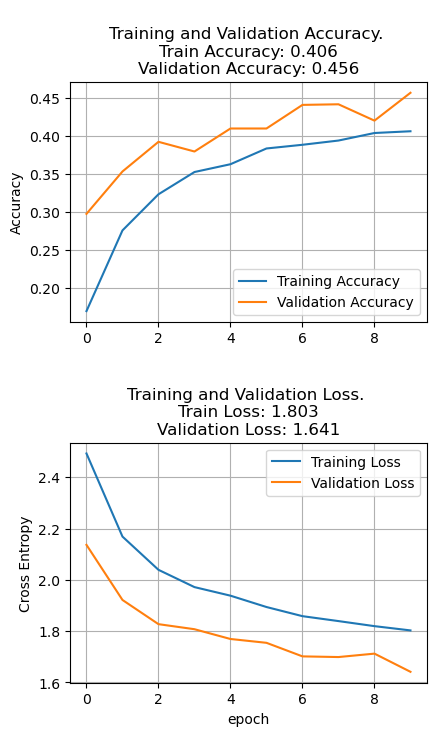

In [23]:
plot_history(history)

In [24]:
# for fine-tuning the model
# nr_base_layers = len(vgg19_base_model.layers)
# print("VGG19 base layers = ", nr_base_layers)    

# history = fit_model(vgg19_model, vgg19_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

In [26]:
accuracy_score = vgg19_model.evaluate(validation_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

40/40 [==============================] - 4s 92ms/step - loss: 1.6414 - accuracy: 0.4563
[1.641420602798462, 0.4563491940498352]
Accuracy: 45.63%
Loss: 1.641


Testing on Validation data first

In [27]:
validation_generator.reset()

vgg19_val_preds = vgg19_model.predict(validation_generator)
vgg19_val_pred_classes = np.argmax(vgg19_val_preds, axis=1)

40/40 [==============================] - 4s 90ms/step


Testing on Testing data

In [28]:
test_generator.reset()

vgg19_test_preds = vgg19_model.predict(test_generator)
vgg16_test_pred_classes = np.argmax(vgg19_test_preds, axis=1)

169/169 [==============================] - 28s 164ms/step


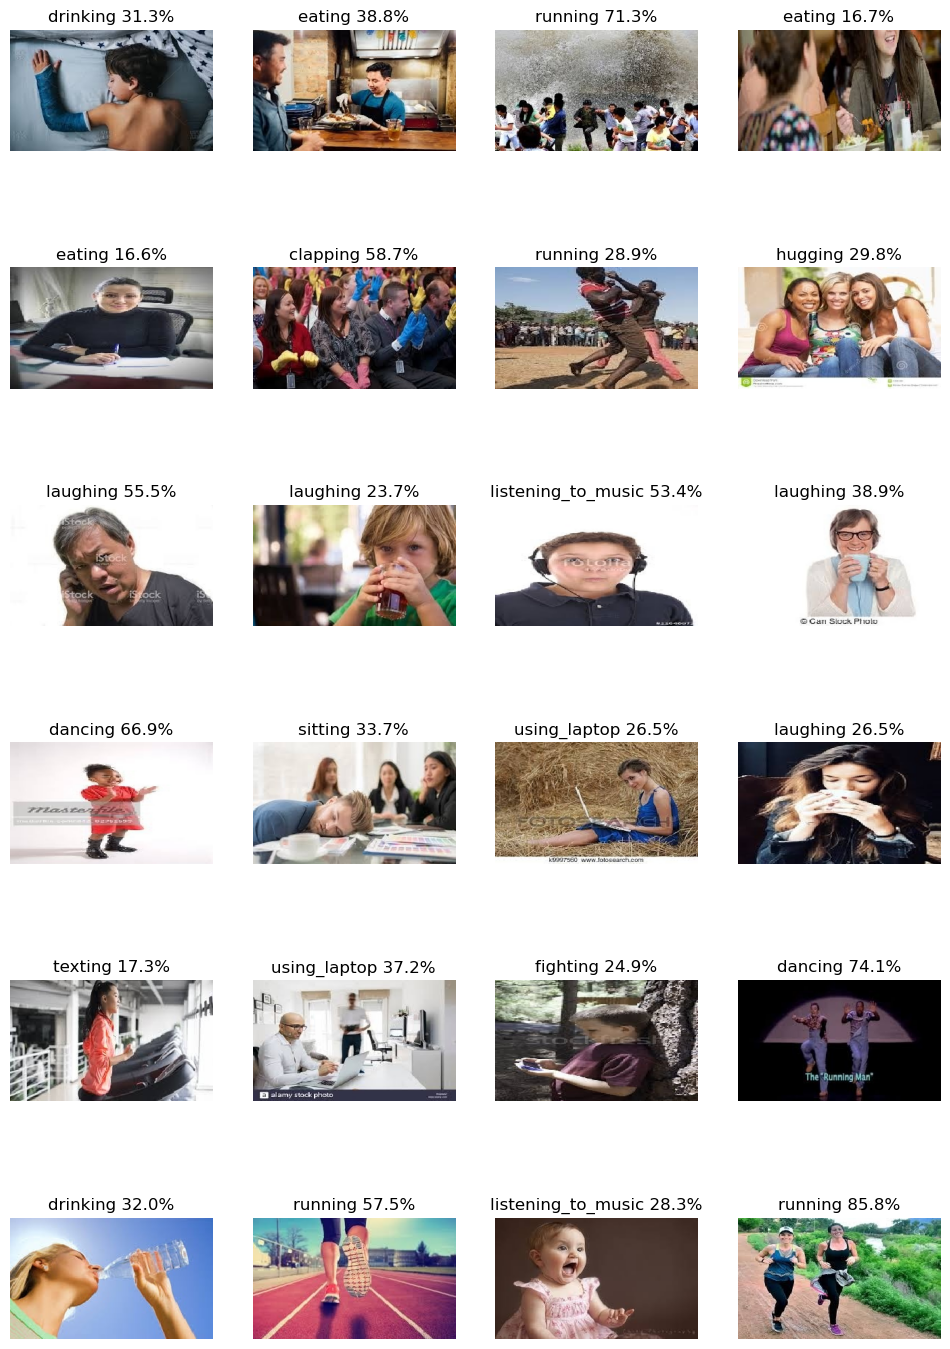

In [29]:
test_generator.reset()
x = next(test_generator)
plot_images(x, None, vgg19_test_preds)

#### Approach 2: Using Inception as a base model

In [30]:
# load the InceptionResNetV2 architecture with imagenet weights as base
inception_base_model = tf.keras.applications.InceptionResNetV2(
                     include_top = False,
                     weights = 'imagenet',
                     input_shape = (image_height, image_width, 3)
                     )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
inception_model = create_model(inception_base_model)
inception_model.summary()
history = fit_model(inception_model, inception_base_model, epochs = TRAINING_EPOCHS)

219055592/219055592 [==============================] - 9s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 89, 149, 32)  864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 89, 149, 32)  96         ['conv2d[0][0]']                 
 alization)                                                                                       
                         

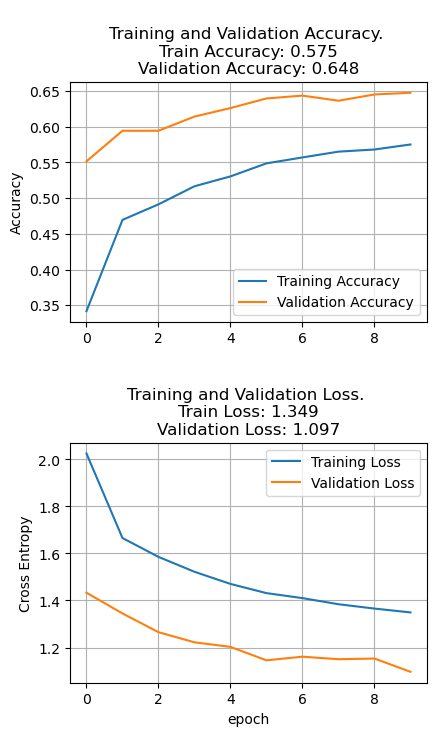

In [31]:
plot_history(history)

In [32]:
# for fine-tuning the model
# nr_base_layers = len(inception_base_model.layers)
# print("Inception base layers = ", nr_base_layers)    

# history = fit_model(inception_model, inception_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

In [34]:
accuracy_score = inception_model.evaluate(validation_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

40/40 [==============================] - 5s 121ms/step - loss: 1.0968 - accuracy: 0.6476
[1.0968316793441772, 0.6476190686225891]
Accuracy: 64.76%
Loss: 1.097


In [35]:
validation_generator.reset()
inception_val_preds = inception_model.predict(validation_generator)
inception_val_pred_classes = np.argmax(inception_val_preds, axis=1)

40/40 [==============================] - 8s 114ms/step


In [36]:
test_generator.reset()
inception_test_preds = inception_model.predict(test_generator)
inception_test_pred_classes = np.argmax(inception_test_preds, axis=1)

169/169 [==============================] - 24s 123ms/step


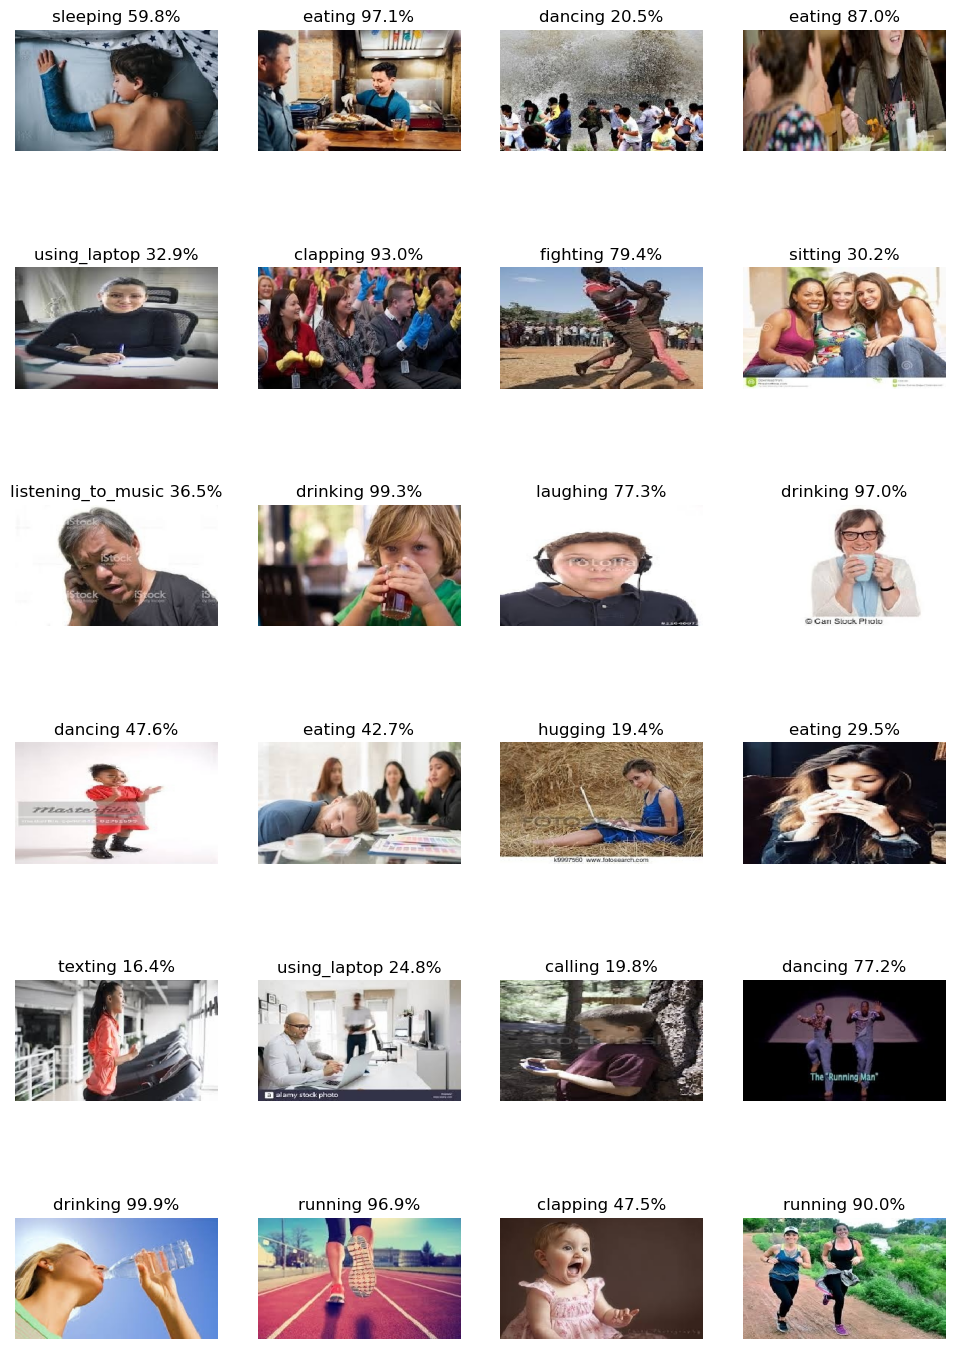

In [37]:
test_generator.reset()
x = next(test_generator)
plot_images(x, None, inception_test_preds)

#### Approach 3: Using Xception as a base model

In [38]:
# load the xception architecture with imagenet weights as base
xception_base_model = tf.keras.applications.xception.Xception(
                                 include_top = False,
                                 weights = 'imagenet',
                                 input_shape = (image_height, image_width, 3)
                                 )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
xception_model = create_model(xception_base_model)
xception_model.summary()
history = fit_model(xception_model, xception_base_model, epochs = TRAINING_EPOCHS)

83683744/83683744 [==============================] - 4s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 89, 149, 32)  864         ['input_3[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 89, 149, 32)  128        ['block1_conv1[0][0]']           
 ation)                                                                                           
                           

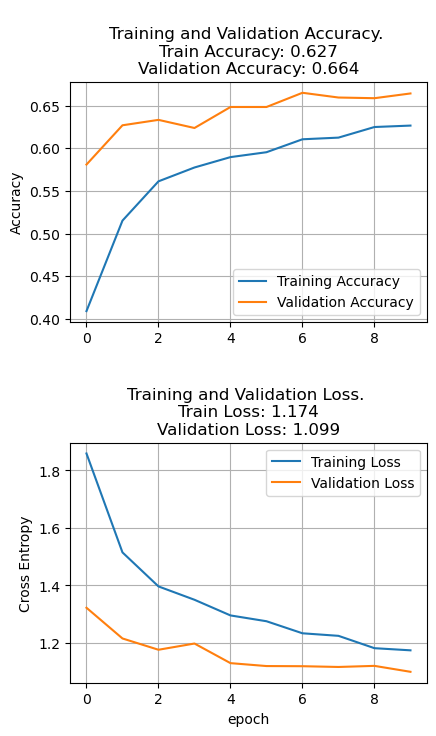

In [39]:
plot_history(history)

In [40]:
# for fine-tuning the model
# nr_base_layers = len(xception_base_model.layers)
# print("xception base layers = ", nr_base_layers)    

# history = fit_model(xception_model, xception_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

In [42]:
accuracy_score = xception_model.evaluate(validation_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

40/40 [==============================] - 4s 90ms/step - loss: 1.0994 - accuracy: 0.6643
[1.099400281906128, 0.6642857193946838]
Accuracy: 66.43%
Loss: 1.099


In [43]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
validation_generator.reset()

xception_val_preds = xception_model.predict(validation_generator)
xception_val_pred_classes = np.argmax(xception_val_preds, axis = 1)

40/40 [==============================] - 5s 96ms/step


In [44]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()

xception_test_preds = xception_model.predict(test_generator)
xception_test_pred_classes = np.argmax(xception_test_preds, axis = 1)

169/169 [==============================] - 16s 87ms/step


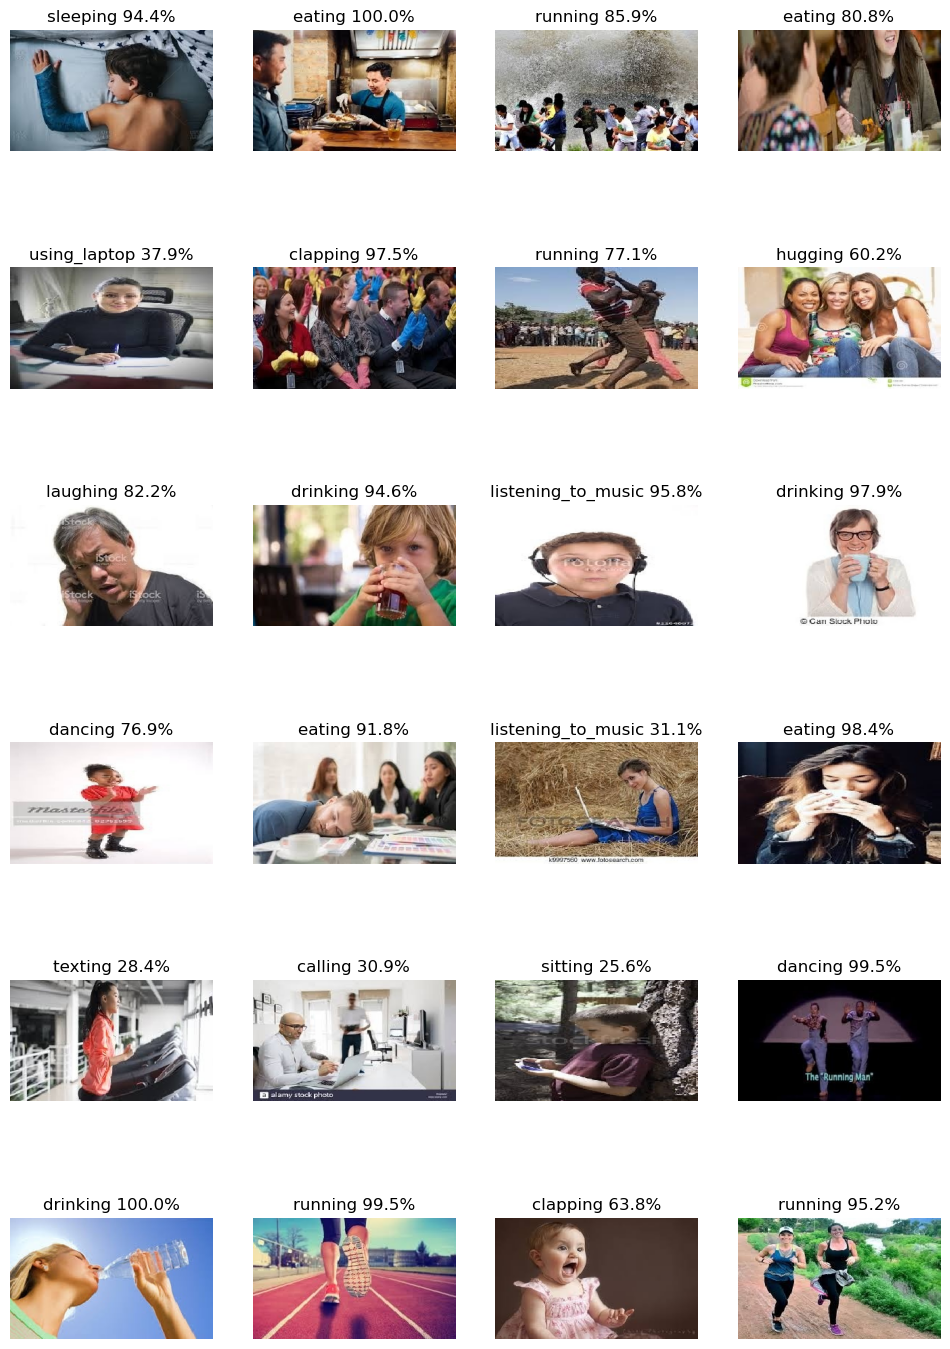

In [45]:
test_generator.reset()
x = next(test_generator)
plot_images(x, None, xception_test_preds)

#### Confusion Matrix of all models

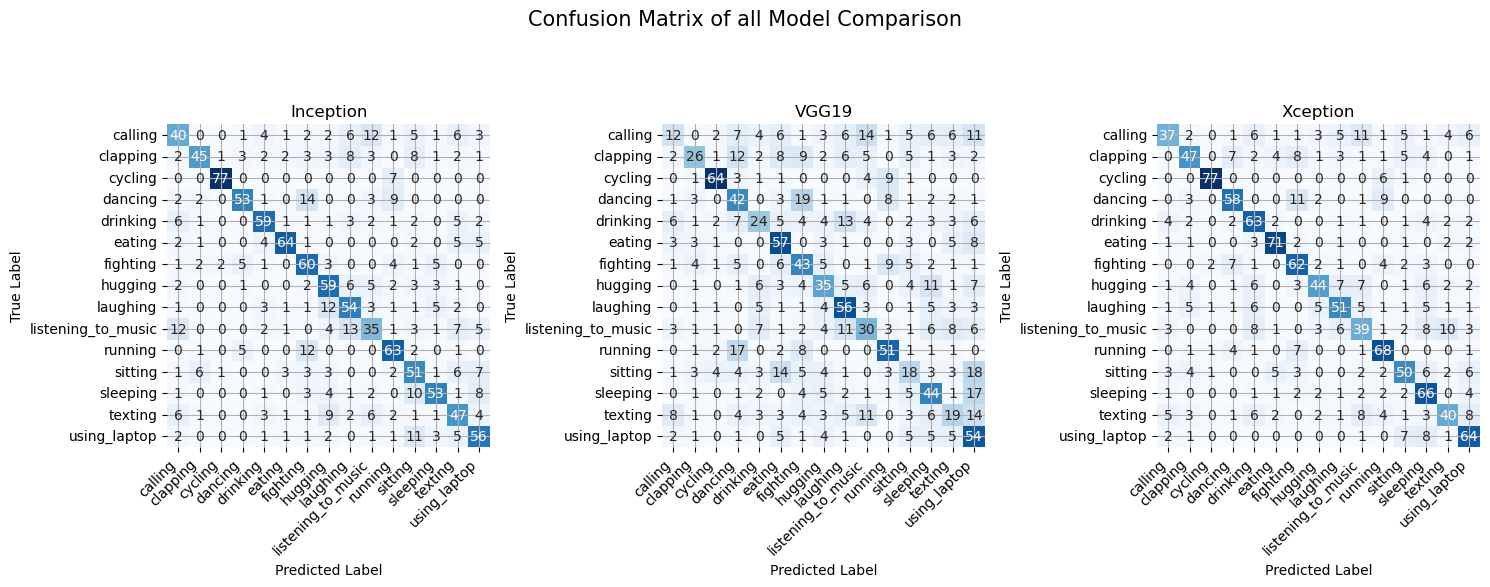

In [48]:
# Display confusion matrix
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

true_classes = validation_generator.classes

plot_heatmap(true_classes, inception_val_pred_classes, class_names, ax1, title = "Inception")    
plot_heatmap(true_classes, vgg19_val_pred_classes, class_names, ax2, title = "VGG19")    
plot_heatmap(true_classes, xception_val_pred_classes, class_names, ax3, title = "Xception")    

fig.suptitle("Confusion Matrix of all Model Comparison", fontsize = 15)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()